# Imports and installs

In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GINConv, GCNConv, GATConv
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng()

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Utilities for generating a synthetic dataset of Kripke structures

To model an LTS system, I generate random directed graphs using the edge probability 0.05. Example below:

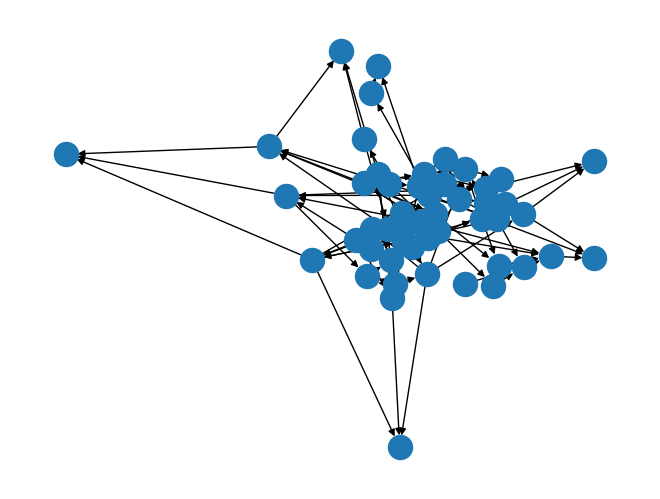

In [3]:
digraph = nx.erdos_renyi_graph(50, 0.05, directed=True)
nx.draw(digraph)

In [4]:
digraph.edges, digraph.nodes

(OutEdgeView([(0, 2), (0, 10), (0, 13), (0, 20), (0, 42), (1, 19), (1, 41), (2, 3), (2, 27), (2, 29), (5, 25), (5, 46), (6, 3), (6, 31), (6, 49), (7, 26), (8, 2), (8, 24), (8, 36), (9, 41), (10, 3), (10, 12), (10, 15), (10, 29), (10, 39), (11, 4), (12, 1), (12, 10), (13, 0), (13, 48), (14, 31), (14, 43), (16, 34), (16, 43), (17, 19), (17, 32), (18, 0), (18, 27), (19, 26), (19, 36), (20, 15), (20, 34), (20, 47), (21, 4), (21, 5), (21, 20), (22, 48), (23, 6), (23, 12), (23, 39), (23, 42), (23, 48), (24, 8), (24, 9), (24, 17), (26, 49), (28, 1), (28, 7), (28, 19), (28, 30), (28, 37), (29, 8), (29, 16), (29, 30), (29, 32), (30, 19), (30, 36), (31, 38), (32, 41), (32, 42), (33, 41), (34, 29), (35, 6), (35, 20), (35, 23), (36, 44), (37, 23), (38, 12), (39, 21), (39, 28), (40, 1), (40, 2), (40, 18), (40, 21), (40, 24), (41, 42), (42, 46), (43, 5), (43, 13), (43, 15), (43, 19), (43, 47), (44, 6), (44, 11), (44, 16), (44, 46), (45, 16), (45, 25), (47, 20), (47, 27), (47, 39), (48, 23), (49, 25)

## Forall until

In [5]:
def identify_nodes_forall_until(digraph, nodes_where_q_is_true, nodes_where_p_is_true, node, path_length):
    if path_length == 0:
        nodes_where_q_is_true.add(node)
        return
    for neighbour in digraph.neighbors(node):
        nodes_where_p_is_true.add(neighbour)

    for n in digraph.neighbors(node):
        identify_nodes_forall_until(
            digraph, nodes_where_q_is_true,
            nodes_where_p_is_true, n, path_length - 1
        )

In [6]:
"""
Since the labeling function is generated iteratively, by traversing the digraph
the formula \forall (p \bigcup q) can be true in more nodes than the initially
designed to be true
"""

def check_where_forall_until_is_true(kripke_structure, nodes_where_p_is_true, nodes_where_q_is_true):
    true_nodes = set()

    def rec_check_where_forall_until_is_true(node):
        if node in nodes_where_q_is_true:
            return True
        elif node not in nodes_where_p_is_true:
            return False
        else:
            return all([
                rec_check_where_forall_until_is_true(neighbour)
                for neighbour in kripke_structure.neighbors(node)
            ])

    for node in kripke_structure.nodes:
        if rec_check_where_forall_until_is_true(node):
            true_nodes.add(node)
    return true_nodes

In [7]:
def generate_forall_until_single_kripke_structure(num_nodes, num_nodes_true, path_length=2, edge_probability=0.05):
    digraph = nx.erdos_renyi_graph(num_nodes, edge_probability, directed=True)

    nodes_where_q_is_true = set()
    nodes_where_p_is_true = np.random.choice(
        num_nodes, num_nodes_true, replace=False
    )
    nodes_where_p_is_true = set(nodes_where_p_is_true)
    original_set_nodes_where_p_is_true = nodes_where_p_is_true.copy()

    for node in original_set_nodes_where_p_is_true:
        identify_nodes_forall_until(
            digraph, nodes_where_q_is_true, nodes_where_p_is_true,
            node, np.random.randint(0, path_length, 1)
        )

    return digraph, nodes_where_p_is_true, nodes_where_q_is_true

In [8]:
def generate_forall_until_dataset(num_graphs, num_nodes=1000, num_true_nodes=15):
    dataset = []

    for _ in range(num_graphs):
        digraph, nodes_where_p_is_true, nodes_where_q_is_true = generate_forall_until_single_kripke_structure(num_nodes, num_true_nodes)
        true_nodes = check_where_forall_until_is_true(
            digraph, nodes_where_p_is_true, nodes_where_q_is_true
        )
        digraph_torch = from_networkx(digraph)
        digraph_torch.x = torch.tensor([
            [node in nodes_where_p_is_true, node in nodes_where_q_is_true]
            for node in digraph.nodes()
        ], dtype=torch.float).to(device)
        digraph_torch.y = torch.tensor([
            [1 * (node in true_nodes), 1 - 1 * (node in true_nodes)]
            for node in digraph.nodes()
        ], dtype=torch.float).to(device)

        print(f'Generated a dataset with {len(true_nodes)} target 1 nodes')

        dataset.append(digraph_torch)

    return dataset

# Define the GNN network used in further experiments

In [9]:
class GNNetwork(nn.Module):
    def __init__(self, num_layers, in_features, hidden_dim, out_dim, gnn_layer='GINConv'):
        super(GNNetwork, self).__init__()
        if gnn_layer == 'GCNConv':
            self.gnn_layers = nn.ModuleList([
                GCNConv(in_features, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(),
            ])

            for _ in range(max(0, num_layers - 1)):
                self.gnn_layers.extend([
                    GCNConv(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.LeakyReLU(),
                ])
        elif gnn_layer == 'GATConv':
            self.gnn_layers = nn.ModuleList([
                GATConv(in_features, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(),
            ])

            for _ in range(max(0, num_layers - 1)):
                self.gnn_layers.extend([
                    GATConv(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.LeakyReLU(),
                ])
        elif gnn_layer == 'GINConv':
            self.gnn_layers = nn.ModuleList([
                GINConv(nn.Linear(in_features, hidden_dim)),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(),
            ])

            for _ in range(max(0, num_layers - 1)):
                self.gnn_layers.extend([
                    GINConv(nn.Linear(hidden_dim, hidden_dim)),
                    nn.BatchNorm1d(hidden_dim),
                    nn.LeakyReLU(),
                ])
        else:
            raise NotImplementedError

        self.classification_head = nn.ModuleList([
            nn.Linear(hidden_dim, 2 * hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(2 * hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim // 2, out_dim),
        ])



    def forward(self, X, A) -> torch.Tensor:
        temp = X

        for index, layer in enumerate(self.gnn_layers):
            if index % 3 == 0:
                temp = layer(temp, A) # GINConv layer
            else:
                temp = layer(temp) # LeakyReLU activation or BatchNorm1d

        for index, layer in enumerate(self.classification_head):
            temp = layer(temp)

        return temp


# Utilities for training the network

In [10]:
def train(model, num_epochs, train_dataset, test_dataset, lr=0.005, weight_decay=0.0005):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = F.binary_cross_entropy_with_logits
    test_accuracies = []
    train_accuracies = []
    train_loss = []

    for train_graph in train_dataset:
        data = train_graph.to(device)
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            preds = model(data.x, data.edge_index).to(device)
            target = data.y
            target = target.to(device)
            preds_class = preds.float().to(device)
            loss = loss_function(preds_class, target)
            predicted_classes = torch.softmax(preds_class, dim=1).argmax(dim=1)
            accuracy = torch.sum(predicted_classes == data.y.argmax(dim=1)) / len(data.x)

            train_accuracies.append(accuracy.item())
            train_loss.append(loss.item())

            test_x, test_edge_index = test_dataset.x.to(device), test_dataset.edge_index.to(device)
            test_y = test_dataset.y.to(device)
            test_preds = model(test_x, test_edge_index).float().to(device)
            test_accuracy = torch.sum(torch.softmax(test_preds, dim=1).argmax(dim=1) == test_y.argmax(dim=1)) / len(test_dataset.x)
            test_accuracies.append(test_accuracy.item())

            print(f'[Epoch {epoch}] Loss: {loss}, Train accuracy: {accuracy}, Test accuracy: {test_accuracy}, train preds differ in {min(predicted_classes.shape[0]-predicted_classes.sum(), predicted_classes.sum())} instances')
            loss.backward()
            optimizer.step()

    return model, train_accuracies, test_accuracies, train_loss


# Testing expressivity of the GNN

## ∀ (φ ⋃ ψ) operator

### Generating the train and test Kripke structure dataset

In [11]:
train_dataset = generate_forall_until_dataset(1, 2000, 30)
test_dataset = generate_forall_until_dataset(1, 1000, 20)

Generated a dataset with 1229 target 1 nodes
Generated a dataset with 324 target 1 nodes


Baseline: always answering 1 or always answering 0

In [12]:
baseline_train_min, baseline_train_max = 1 - train_dataset[0].y.argmax(dim=1).sum() / train_dataset[0].y.shape[0], train_dataset[0].y.argmax(dim=1).sum() / train_dataset[0].y.shape[0]
baseline_train_min, baseline_train_max = min(baseline_train_min, baseline_train_max).item(), max(baseline_train_min, baseline_train_max).item()
print(baseline_train_min, baseline_train_max)

0.3855000138282776 0.6144999861717224


In [13]:
baseline_test_min, baseline_test_max = 1 - test_dataset[0].y.argmax(dim=1).sum() / test_dataset[0].y.shape[0], test_dataset[0].y.argmax(dim=1).sum() / test_dataset[0].y.shape[0]
baseline_test_min, baseline_test_max = min(baseline_test_min, baseline_test_max).item(), max(baseline_test_min, baseline_test_max).item()
print(baseline_test_min, baseline_test_max)

0.32399994134902954 0.6760000586509705


### GCN Expressivity testing

In [14]:
model = GNNetwork(16, 2, 8, 2, gnn_layer='GCNConv').to(device)
model, train_accuracies, test_accuracies, train_loss = train(model, 200, train_dataset, test_dataset[0])

[Epoch 0] Loss: 0.7418602705001831, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 1] Loss: 0.7374176383018494, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 2] Loss: 0.7336589097976685, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 3] Loss: 0.730195939540863, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 4] Loss: 0.7270204424858093, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 5] Loss: 0.7243071794509888, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 6] Loss: 0.7219254970550537, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 7] Loss

##### GCN plots

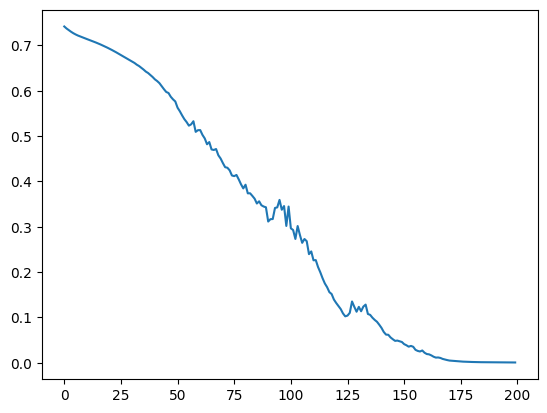

In [15]:
plt.plot(range(len(train_loss)), train_loss)

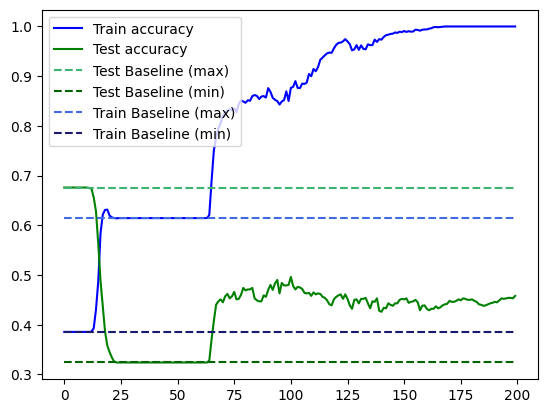

In [16]:
plt.plot(range(len(train_accuracies)), train_accuracies, color='blue', label='Train accuracy')
plt.plot(range(len(test_accuracies)), test_accuracies, color='green', label='Test accuracy')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_test_max], '--', color='mediumseagreen', label='Test Baseline (max)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_test_min], '--', color='darkgreen', label='Test Baseline (min)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_train_max], '--', color='royalblue', label='Train Baseline (max)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_train_min], '--', color='midnightblue', label='Train Baseline (min)')
plt.legend()

### GIN Expresivity testing

In [17]:
model = GNNetwork(16, 2, 8, 2, gnn_layer='GINConv').to(device)
model, train_accuracies, test_accuracies, train_loss = train(model, 200, train_dataset, test_dataset[0])

[Epoch 0] Loss: 0.7466751337051392, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 1] Loss: 0.7439315319061279, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 2] Loss: 0.7416971325874329, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 3] Loss: 0.7397018074989319, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 4] Loss: 0.7378048300743103, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 5] Loss: 0.7359960079193115, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 6] Loss: 0.7343146204948425, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 7] Los

#### GIN Plots

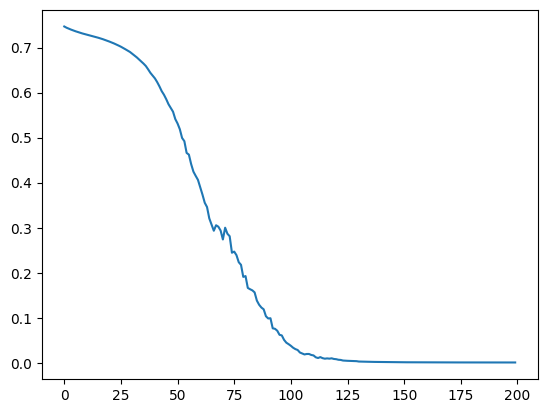

In [18]:
plt.plot(range(len(train_loss)), train_loss)

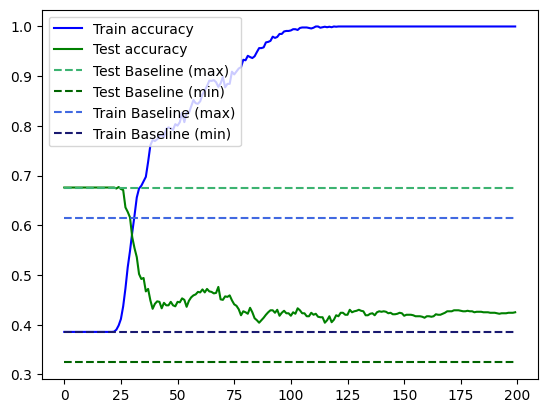

In [19]:
plt.plot(range(len(train_accuracies)), train_accuracies, color='blue', label='Train accuracy')
plt.plot(range(len(test_accuracies)), test_accuracies, color='green', label='Test accuracy')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_test_max], '--', color='mediumseagreen', label='Test Baseline (max)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_test_min], '--', color='darkgreen', label='Test Baseline (min)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_train_max], '--', color='royalblue', label='Train Baseline (max)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_train_min], '--', color='midnightblue', label='Train Baseline (min)')
plt.legend()

### GAT Expressivity testing

In [20]:
model = GNNetwork(16, 2, 8, 2, gnn_layer='GATConv').to(device)
model, train_accuracies, test_accuracies, train_loss = train(model, 200, train_dataset, test_dataset[0])

[Epoch 0] Loss: 0.7467985153198242, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 1] Loss: 0.743349552154541, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 2] Loss: 0.7412322163581848, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 3] Loss: 0.7384220361709595, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 4] Loss: 0.7359102368354797, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 5] Loss: 0.7334177494049072, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 6] Loss: 0.7300382256507874, Train accuracy: 0.3855000138282776, Test accuracy: 0.6760000586509705, train preds differ in 0 instances
[Epoch 7] Loss

#### GAT Plots

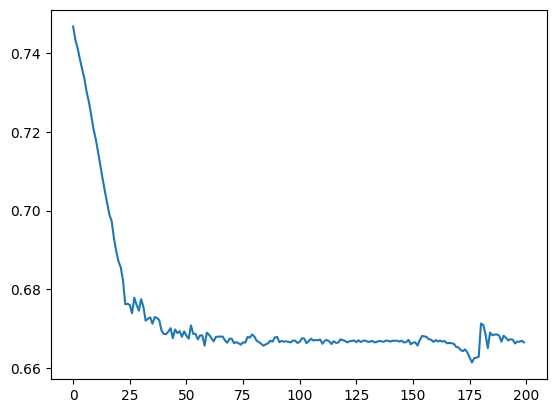

In [21]:
plt.plot(range(len(train_loss)), train_loss)

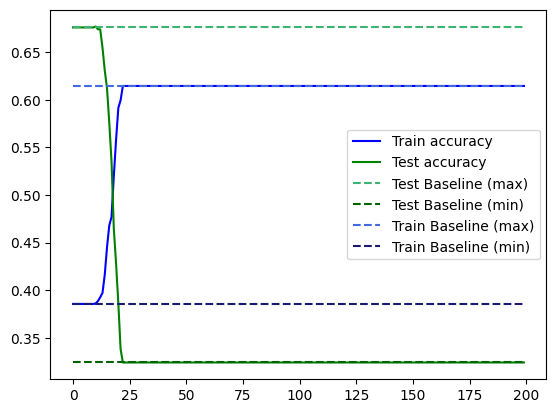

In [22]:
plt.plot(range(len(train_accuracies)), train_accuracies, color='blue', label='Train accuracy')
plt.plot(range(len(test_accuracies)), test_accuracies, color='green', label='Test accuracy')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_test_max], '--', color='mediumseagreen', label='Test Baseline (max)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_test_min], '--', color='darkgreen', label='Test Baseline (min)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_train_max], '--', color='royalblue', label='Train Baseline (max)')
plt.plot(range(len(train_accuracies)), len(train_accuracies) * [baseline_train_min], '--', color='midnightblue', label='Train Baseline (min)')
plt.legend()